<a href="https://colab.research.google.com/github/Segrey372017/gb_ML_in_business/blob/main/ssmirnov_ml_business_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, classification_report

## Кейс 2 - определение ССЗ

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

Ссылка на google drive: https://drive.google.com/file/d/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G

In [3]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2022-04-02 11:12:59--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 142.250.141.101, 142.250.141.113, 142.250.141.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mkcgfjrs1abmdgjl5070tlfhqit5h66q/1648897950000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download [following]
--2022-04-02 11:13:00--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mkcgfjrs1abmdgjl5070tlfhqit5h66q/1648897950000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-00-c0-docs.googleusercontent.com (doc-00-c0

In [4]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [5]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [6]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [7]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

### Задание 1
<p> Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта</p>

### Обучение моделей классификаторов
<p> Обучим 3 модели классификатора на имеющемся датасете, создав соответсвующие пайплайны: </p>
<ul> 
<li> 'Classifier1' - К-ближайших соседей </li>
<li> 'Classifier2' - Случайный лес </li>
<li> 'Classifier3' - классификатор на основе LightGBM </li>
</ul>

In [8]:
# импорты соответсвующих компонентов
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


In [9]:
# установка и иморт lightGBN
from lightgbm import LGBMClassifier

In [10]:
# инициализируем соответствующие пайпланы классификаторов
classifier1 = Pipeline([
    ('features', feats),
    ('classifier', KNeighborsClassifier()),
])

classifier2 = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier()),
])

classifier3 = Pipeline([
    ('features', feats),
    ('classifier', LGBMClassifier()),
])

In [11]:
# Напишем фунции для кросс-валидации и получения предсказаний от  моделей

# запустим кросс-валидацию
def make_cv(c_pipe, X_train, y_train):
    """
    Рассчитывает результативность модели методом кросс-валидации на тренировочных
    данных
    """
    cv_scores = cross_val_score(c_pipe, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    return print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайны на всем тренировочном датасете
def get_score (c_pipe, X_train, y_train):
    """
    Возвращает вероятности предсказания первого класса
    """
    c_pipe.fit(X_train, y_train)
    return c_pipe.predict_proba(X_test)[:, 1]

In [12]:
# выполняем кросс-валидацию по всем моделям
%%time
make_cv(classifier1, X_train, y_train)
make_cv(classifier2, X_train, y_train)
make_cv(classifier3, X_train, y_train)

CV score is 0.6912766334769298+-0.0034373176868339114
CV score is 0.7746848682352743+-0.0029623862176379827
CV score is 0.8019383066904299+-0.003285200200143236
CPU times: user 1min 21s, sys: 981 ms, total: 1min 22s
Wall time: 1min 40s


Кросс-валидация показала, что выбранные модели работаю устойчиво, разброс результатов по фолдам составляет 3-4 десятых процента. Чем сложнее модель тем выше результат. Ожидаемо градиентный бустинг показал лучший результа порядка 80

In [14]:
# получим  предсказания от всех моделей, обучив их на полном тренировочном наборе
%%time
y_KNN_score = get_score(classifier1, X_train, y_train)
y_RF_score = get_score(classifier2, X_train, y_train)
y_LGBM_score = get_score(classifier3, X_train, y_train)

CPU times: user 16.5 s, sys: 116 ms, total: 16.6 s
Wall time: 16.5 s


### Задание 2
<p> Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)</p>

Посчитаем precision/recall/f_score

In [15]:
# также обернем подбор порога вероятностей в фунцию для использованя на каждой модели

def get_treshold(y_test, y_score, b = 1):
    """
    Функция для подбора оптимального порога вероятности.
    Максимизирует F-score
    """

    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    # заодно расчитаем метрику ROC_AUC поскольку она в домашнем заднии
    auc = roc_auc_score(y_test, y_score)
    # отдадим в виде словаря порог вероятности и метрики
    return {'BestTreshold': thresholds[ix], 'Precision': precision[ix], 'Recall': recall[ix], 'ROC_AUC': auc, 'F-Score':fscore[ix]}

In [16]:
stat1 = get_treshold(y_test, y_KNN_score)
stat2 = get_treshold(y_test, y_RF_score)
stat3 = get_treshold(y_test, y_LGBM_score)

In [17]:
res = pd.DataFrame(data = [stat1, stat2, stat3], index = ['KNN', 'RandomForest', 'LightGBM']) # выведем метрики
res

,BestTreshold,Precision,Recall,ROC_AUC,F-Score
KNN,0.400000,0.588468,0.821889,0.694098,0.685863
RandomForest,0.383333,0.662973,0.785714,0.770985,0.719144
LightGBM,0.355647,0.667099,0.829954,0.801182,0.739668


По показатели полноты хорошие результаты показали модели KNN и Лёгкий бустинг (LightGBM). В свою очередь наибольше точностью 67% и показтелем F-score лидерство за LightGMB. Наиболее сложной моделью.

Нарисуем roc auc кривую. Для модели LightGBM

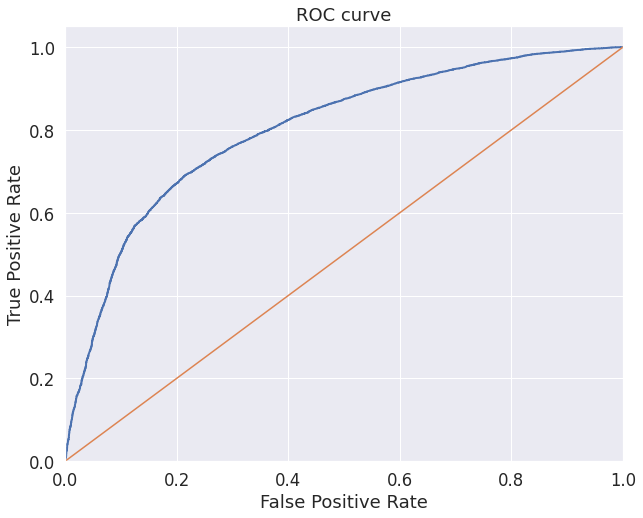

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_LGBM_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Посмотрим на матрицу ошибок

In [24]:
# Функциюя для отрисовки матрицы соответсвия
def show_matrix(y_true, y_pred, classes, title):
    """
    Отрисовка матрицы соответсвия средствами seaborn

    """
    plt.title(title)
    cnf = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cnf, cmap = 'Blues', annot = True, fmt = ".1f", linecolor= 'black',
                linewidths= 1, xticklabels= classes, yticklabels= classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    
    plt.figure(figsize = (8,8))
    plt.show()

    return

Посчитаем FPR, TPR для каждой модели

In [39]:
# также обернем расчет в функцию для многократного использования
def cnf_metrics(y_true, y_pred):
    """
    Расчитывает показатели точности классификаци из матрицы соответсвия
    """
    cnf = confusion_matrix(y_true, y_pred)
    TN = cnf[0][0]
    FN = cnf[1][0]
    TP = cnf[1][1]
    FP = cnf[0][1]

    TPR = TP / (TP+FN)
    FPR = FP / (FP+TN)
    TNR = TN / (FP+TN)
    print(f'True positive rate {TPR}, False positive rate {FPR}, True negative rate {TNR}')
    #вернем показатели TN, FN, TP, FP для дальнейших расчетов
    return {'TN':TN, 'FN':FN, 'TP':TP, 'FP':FP, 'cnf_mat':cnf}

Для модели KNN

True positive rate 0.6185483870967742, False positive rate 0.322108843537415, True negative rate 0.677891156462585
{'TN': 5979, 'FN': 3311, 'TP': 5369, 'FP': 2841, 'cnf_mat': array([[5979, 2841],
       [3311, 5369]])}


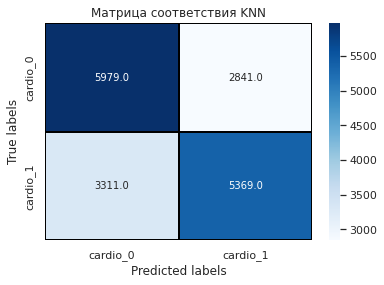

<Figure size 576x576 with 0 Axes>

In [41]:
KNN_cnf = cnf_metrics(y_test, y_KNN_score > res.BestTreshold.loc['KNN'])
print(KNN_cnf)
show_matrix(y_test, y_KNN_score > res.BestTreshold.loc['KNN'], classes = ['cardio_0', 'cardio_1'],
            title  = 'Матрица соответствия KNN')

Для модели RandomForest

True positive rate 0.7855990783410138, False positive rate 0.3930839002267574, True negative rate 0.6069160997732427
{'TN': 5353, 'FN': 1861, 'TP': 6819, 'FP': 3467, 'cnf_mat': array([[5353, 3467],
       [1861, 6819]])}


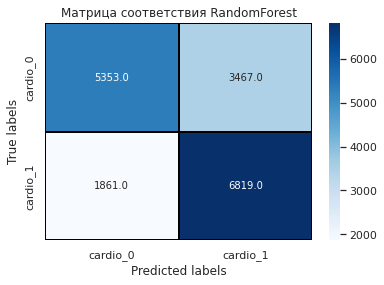

<Figure size 576x576 with 0 Axes>

In [44]:
RF_cnf = cnf_metrics(y_test, y_RF_score > res.BestTreshold.loc['RandomForest'])
print(RF_cnf)
show_matrix(y_test, y_RF_score > res.BestTreshold.loc['RandomForest'], classes = ['cardio_0', 'cardio_1'],
            title  = 'Матрица соответствия RandomForest')

True positive rate 0.8298387096774194, False positive rate 0.4075963718820862, True negative rate 0.5924036281179138
{'TN': 5225, 'FN': 1477, 'TP': 7203, 'FP': 3595, 'cnf_mat': array([[5225, 3595],
       [1477, 7203]])}


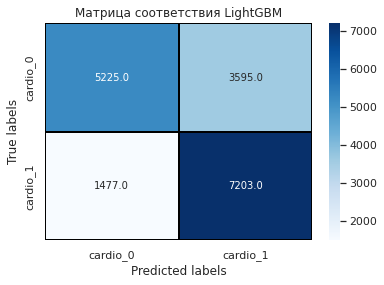

<Figure size 576x576 with 0 Axes>

In [45]:
LGBM_cnf = cnf_metrics(y_test, y_LGBM_score > res.BestTreshold.loc['LightGBM'])
print(LGBM_cnf)
show_matrix(y_test, y_LGBM_score > res.BestTreshold.loc['LightGBM'], classes = ['cardio_0', 'cardio_1'],
            title  = 'Матрица соответствия LightGBM')


Пусть:

- стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 1400р



- лишних тестов сделали FP = cnf_matrix[0][1]
- пропустили больных FN = cnf_matrix[1][0]
- правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:


In [47]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

### Задание 3
<p> Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока:
<ul>
<li> стоимость лечения 15000р, если сделали тест и начали лечить вовремя </li>
<li>стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы </li>
<li>стоимость теста 1400р </li>
</ul>
</p>

Расчет экономического эффекта тажке обернем в функцию

In [46]:
def fin_results( cnf_metrics, rubl_test, rubl_early_treatment, rubl_late_treatment):
    """
    Проводит сравнение экономического эффекта от применения модели ML и без его применения
    """
    rubl_1 = (cnf_metrics['FN'] + cnf_metrics['TP']) * rubl_late_treatment
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)

    rubl_test_all = np.sum(cnf_metrics['cnf_mat']) * rubl_test + (cnf_metrics['FN'] + cnf_metrics['TP']) * rubl_early_treatment
    print('расходы, если делать тест всем и лечить группу большых:', rubl_test_all)

    rubl_ML = (cnf_metrics['FP'] + cnf_metrics['TP']) * rubl_test + cnf_metrics['FN'] * rubl_late_treatment + cnf_metrics['TP']* rubl_early_treatment
    print('расходы, если использовать МЛ:', rubl_ML)

    print('+'*60, '\n')
    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)
    return



Экономический эффект при применении KNN

In [48]:
fin_results(KNN_cnf, rubl_test, rubl_early_treatment, rubl_late_treatment)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если использовать МЛ: 158249000
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

Расходы "решение не делать тесты - расходы с МL:" 15351000
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": -3549000


Получается использовать модель KNN экономически не выгодно. Так как легче провести тестирование всей популяции чем полагаться на полученную модель.

Экономический эффект при применении RandomForest

In [49]:
fin_results(RF_cnf, rubl_test, rubl_early_treatment, rubl_late_treatment)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если использовать МЛ: 153905400
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

Расходы "решение не делать тесты - расходы с МL:" 19694600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 794600


Применение модели Случайных лесов уже дает экономический эффект по сравнению с поголовным тестированием или лечением больных с симптомами. Тестирование людей, определенных моделью выгоднее тестирования популяции на 794600 рублей.

Экономический эффект при применении LightGBM

### Задание 4
<p> Сделать выводы о том, какая модель справилась с задачей лучше других</p>

In [50]:
fin_results(LGBM_cnf, rubl_test, rubl_early_treatment, rubl_late_treatment)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу большых: 154700000
расходы, если использовать МЛ: 152702200
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

Расходы "решение не делать тесты - расходы с МL:" 20897800
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1997800


Модель градиентного бустинга оказалась нетолько более эффективной по DS метрикам, но и за счет больших значений precision и recall позволяет эффективнее проводить тестирование и снижать затраты на бесполезные тесты. Экономический эффект по-сравнению с поголовным тестированием 1 млн. 998 тыс.



Метрика по деньгам : получить меньше расходов чем при полном тесте

In [51]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

### Задание 5
<p>*Найти порог классификации по деньгам для лучшей модели

    Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    Стоимость теста 1400р
 </p>

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152419200
Расходы "решение не делать тесты - расходы с МL:" 21180800
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 2280800


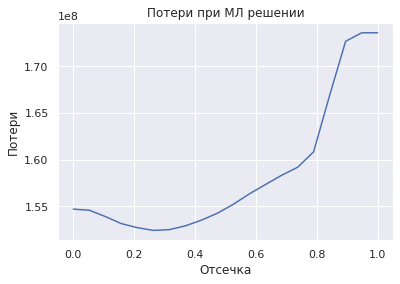

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.3556466453103432


In [52]:
# изменим вызов функции для расчетом по результатам LightGBM
busines_tr = business_threshold_calibrate(y_test,y_LGBM_score, 
                                          res.BestTreshold.loc['LightGBM'],
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', res.BestTreshold.loc['LightGBM'])

Оптимизация порога вероятностей для модели LGBM позволила значительно увеличить ожидаемый финансовый результат с 1,9 млн. рублей до почти 2,3 млн. рублей для тестовой выборки. Причем для бизнес метрики "выгодние" еще сильнее снижать отсечку для повышения recall

True positive rate 0.9091013824884793, False positive rate 0.5852607709750567, True negative rate 0.4147392290249433
{'TN': 3658, 'FN': 789, 'TP': 7891, 'FP': 5162, 'cnf_mat': array([[3658, 5162],
       [ 789, 7891]])}


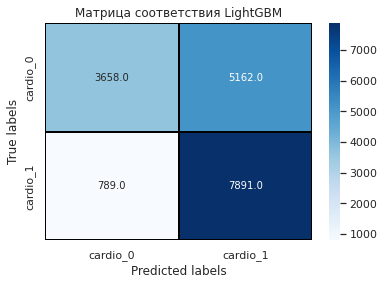

<Figure size 576x576 with 0 Axes>

In [53]:
LGBM_cnf2 = cnf_metrics(y_test, y_LGBM_score > 0.2631578947368421)
print(LGBM_cnf2)
show_matrix(y_test, y_LGBM_score > 0.2631578947368421, classes = ['cardio_0', 'cardio_1'],
            title  = 'Матрица соответствия LightGBM')

In [56]:
print(classification_report(y_test, y_LGBM_score > 0.2631578947368421))


              precision    recall  f1-score   support

           0       0.82      0.41      0.55      8820
           1       0.60      0.91      0.73      8680

    accuracy                           0.66     17500
   macro avg       0.71      0.66      0.64     17500
weighted avg       0.71      0.66      0.64     17500



Действительно, порог по бизнесовой метрикие увеличил показатель recall до 91%, против 83% для DS-метрики. Для данной бизнес задачи оказалось эффективнее пожертвовать точностью распознавания целевого класса с 67% до до 60%, поскольку стоиомсть обследования значительно меньше последствий развития заболевания.
